# Sentiment Analysis using Machine Learning

### Goal of the project

The goal of the project is to develop a machine learning model that can accurately classify the sentiment of product reviews as either positive or negative.

# 1. Loading & Inspecting data

In [247]:
# Importing basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading training and test set
data = pd.read_csv("sentiment_train.csv")
test_data = pd.read_csv("sentiment_test.csv")

# A quick look at the what training data looks like
print(data.head())

                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1


In [248]:
# Check size of dataset, null values and data types for training set
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None


In [249]:
# Check size of dataset, null values and data types for test set
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
None


# 2. Cleaning Data

We need to convert text data into lower case and remove special characters and spaces for training & test data separately, so that we can properly tokenize it at later stage.

In [250]:
# Convert to string type
data['Sentence'] = data['Sentence'].astype(str)
test_data['Sentence'] = test_data['Sentence'].astype(str)

In [251]:
# Convert to lower case
data['Sentence'] = data['Sentence'].str.lower()
test_data['Sentence'] = test_data['Sentence'].str.lower()

In [252]:
# Remove special characters
data['Sentence'] = data['Sentence'].str.replace(r'[^0-9a-zA-Z ]', '', regex=True).str.replace("'",'')

test_data['Sentence'] = test_data['Sentence'].str.replace(r'[^0-9a-zA-Z ]', '', regex=True).str.replace("'",'')

# 3. Exploratory Data Analysis

As this is a classification problem, we want to inspect the distribution of our target variable label. 

In [257]:
# checking the target label distribution in training set
y_train = data['Polarity']
y_test = test_data['Polarity']
y.describe()

count    2400.000000
mean        0.494583
std         0.500075
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Polarity, dtype: float64

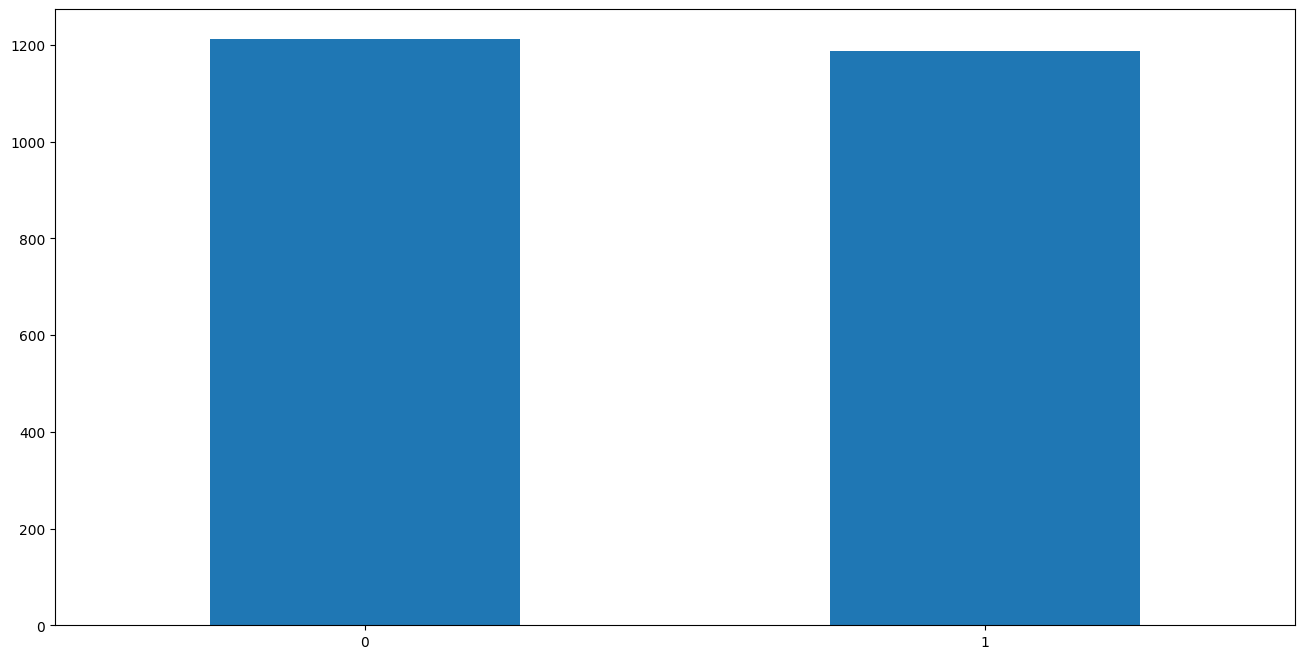

In [258]:
plt.clf()
y.value_counts().plot(kind='bar')
plt.xticks(rotation = 360)
plt.show()

The bar chart shows we have a **balanced** training data here. Hence, we do not need to perform oversampling technique.

One way to inspect our text data is to create a word cloud, which shows the most frequent words by size. To create one, we initialize a WordCloud(). Specifying the stopwords allows us to filter out generic words such as "the" and "and".

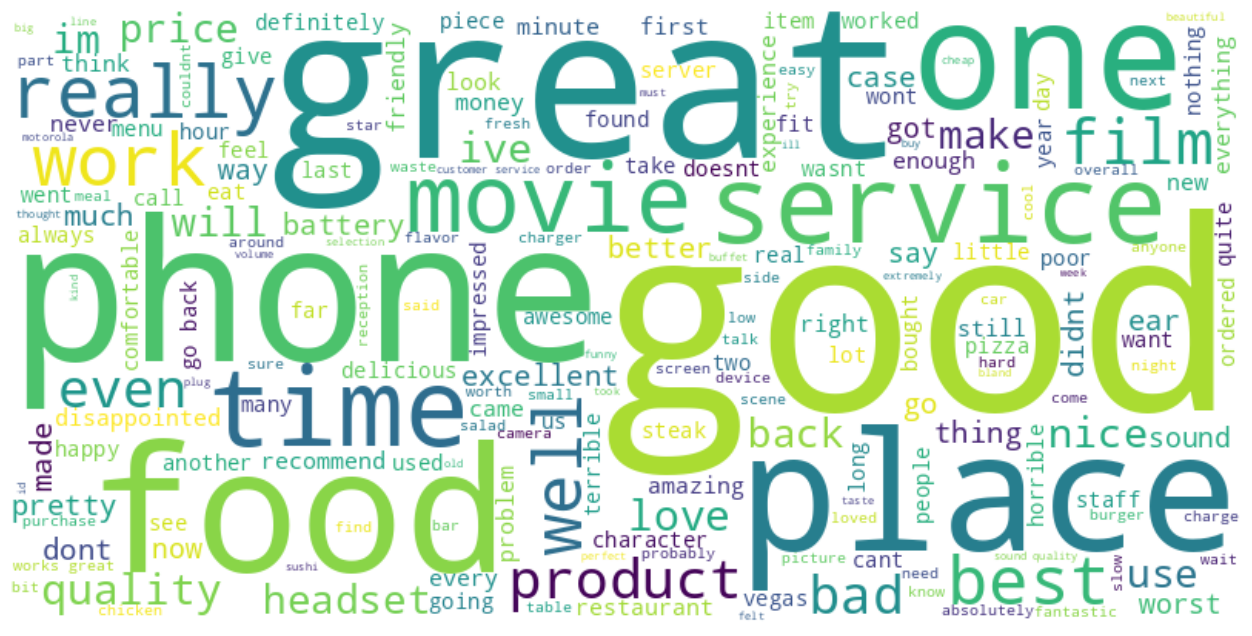

In [259]:
# import packages
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# Concatenate the text review data
reviews = " ".join(data["Sentence"])

# Create the word cloud image
word_cloud = WordCloud(background_color='white',
                       width=800,
                       height=400)

# Generate the word cloud using the review data
word_cloud.generate(reviews)

# Display the word cloud
plt.rcParams["figure.figsize"] = (16, 8)
plt.imshow(word_cloud, interpolation="bilinear") 
plt.axis("off")
plt.show()

# 4. Pre-processing the text data

To pre-process the text, we will use the term frequency-inverse document frequency, or **TfIdf**. TfIdf is a way of calculating the importance of words in a collection of different sets of text (or documents). TfIdf has the advantages of:

* Highlighting words that are common within a document but not across documents.
* Returning low scores for words common across all reviews.
* Penalizing frequent words so we don't need to worry about stop words as much.

In [260]:
# importing useful tools
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Specify the word pattern, Tokenized words in text column to generate a CSR matrix
pattern = r"[a-zA-Z]+"
vect = TfidfVectorizer(
    ngram_range=(1,2), # Consider Uni- and bi-grams
    max_features=500, # Maximum number of features
    tokenizer=word_tokenize, # Define the tokenizer
    token_pattern=pattern, # Define the pattern to extract words
    stop_words=ENGLISH_STOP_WORDS, # Default list of English stop words
)
# fit to the training data
vect.fit(data['Sentence'])

# Create sparse matrix from the vectorizer
tokenized_features = vect.transform(data['Sentence'])

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [261]:
# Create a DataFrame of the new train features
features = pd.DataFrame(data=tokenized_features.toarray(), 
                        columns=vect.get_feature_names_out()
                       )

In [262]:
# Tokenize the test data using trained tokenizer
test_tokenized_features = vect.transform(test_data['Sentence'])

In [263]:
# Create a DataFrame of the new test features
test_features = pd.DataFrame(data=test_tokenized_features.toarray(), 
                        columns=test_vect.get_feature_names_out()
                       )

Let's add a few more features about the nature of the review, calculating different length metrics for the text.

In [264]:
# Generate a number of different length metrics based on the text for training set
data["char_count"] = data['Sentence'].str.count(r"\S")
data["word_count"] = data['Sentence'].str.count(pattern)
data["avg_word_length"] = data["char_count"] / data["word_count"]

# Preview our new columns
data.sample(3)

,Sentence,Polarity,char_count,word_count,avg_word_length
1354,excellent starter wireless headset,0,31,4,7.750000
1711,it lasts less than 3o minutes if i actually tr...,0,90,23,3.913043
1835,the calls drop the phone comes on and off at w...,0,101,24,4.208333


In [265]:
# Generate a number of different length metrics based on the text for test set
test_data["char_count"] = test_data['Sentence'].str.count(r"\S")
test_data["word_count"] = test_data['Sentence'].str.count(pattern)
test_data["avg_word_length"] = test_data["char_count"] / data["word_count"]

It is required to standardize features to bring them all on the same scale using a scaling technique for build a better performing machine learning model. We will use standard scaler on training and test set separately.

In [266]:
# Import tools
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Merge features to define X_train and X_test
X_train = pd.concat([features, data.loc[:, "char_count":]], axis=1)
X_test = pd.concat([test_features, test_data.loc[:, "char_count":]], axis=1)

# Scale training and test set
scaled_X_train = StandardScaler().fit_transform(X_train)
scaled_X_test = StandardScaler().fit_transform(X_test)

# 5. Fitting a model and evaluating it's performance

## Training a basic model

Here our objective is to predict the sentiment of product reviews as either positive or negetive. Ideally, we would like to accurately predict the negetive sentiments of the product. This can help marketing team in screening dissatisfied customers. We will start with **XGBoost** model.

Scikit learn's XGBClassifier is a gradient boosting model with default booster as decision tree. Hence, this can prove to be a good model for our problem. The parameters used for the models are described below:

* I have used XGBClassifier() with 25 boosting rounds to avoid long training times.
* To avoid overfitting the data *max_depth* is kept 2.
* *eval_metric* is set to 'auc' to use Area under the ROC curve as our evaluation metric.
* *random_state* is specified to an integer value to ensure repeatability of the results.

In [267]:
# Import the tools
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(n_estimators=25, max_depth=2, eval_metric='auc', objective='binary:logistic', random_state=13)

# Fit it to the training set
xgb_clf.fit(scaled_X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(scaled_X_test)

# Calculate the accuracy
test_accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

# Print the accuracy
print("Test accuracy:", test_accuracy)

print(classification_report(y_test, preds))

Test accuracy: 0.595
              precision    recall  f1-score   support

           0       0.54      0.95      0.69       287
           1       0.85      0.27      0.41       313

    accuracy                           0.59       600
   macro avg       0.70      0.61      0.55       600
weighted avg       0.70      0.59      0.55       600



__*Accuracy*__ is sufficient measure for our current problem as we do not have an imbalanced dataset. For a balanced problem, the __*F1 score*__ can effectively be ignored. However, we have much room for improvement for the base model. We will find the best parameters using hyperparameter tuning.

## Hyperparameter Tuning

Grid search and random search are the most popular methods for hyperparameter tuning. However, grid search can get computationally expensive if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. This is why I have used __random search__ because it doesn't try all the hyperparameter values.

Parameters used:

* *estimator* is the estimator being fit, here it's XGBoost.
* *param_distributions* is the distribution of possible hyperparameters to use.
* *cv* is Number of cross-validation iterations, set to 3
* *n_iter* is Number of hyperparameter combinations to choose from, set to 3 as we are tuning 3 parameters

In [268]:
# Define a parameter grid
rs_param_grid = {
    # max_depth: values from 3 to 11
    'max_depth': list((range(2,25))),
    # n_estimators: values 10, 25, 40
    'n_estimators':[10,25,40,45,60]
    }

# Insantiate XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(eval_metric='auc', objective='binary:logistic',random_state=13)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=rs_param_grid, cv=3, n_iter=3, random_state=13)

# Train the model on the training set
xgb_rs.fit(scaled_X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found:", xgb_rs.best_params_)
print("Best accuracy found:", xgb_rs.best_score_)

Best parameters found: {'n_estimators': 40, 'max_depth': 13}
Best accuracy found: 0.7083333333333334


Now, we will use the best parameters found to train the model.

In [269]:
# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(n_estimators=40, max_depth=13, eval_metric='auc', objective='binary:logistic', random_state=13)

# Fit it to the training set
xgb_clf.fit(scaled_X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(scaled_X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.90      0.73       287
           1       0.84      0.46      0.60       313

    accuracy                           0.67       600
   macro avg       0.72      0.68      0.66       600
weighted avg       0.73      0.67      0.66       600



The accuracy jumped to 67% from 59% for the base model, which is splendid. However, there are few points to be noted from classification report, with which we will conclude this excercise. 

# 6. Conclusion

Looking at the classification report, we can draw following points to get a business perspective:
* Our model accurately predicts 2/3rd of the product sentiment polarities (accuracy = 67%). This gives us a good confidence in labeling satifaction rate of product reviewers.
* Model can confidently identify a negetive sentiment (recall for '0' class labels = 90%), which is great as by identifying unhappy reviewers and compensating them can avoid opportunity loss in future and help maintain the popularity of brand.
* Out of all reviews that were predicted positive, 84% of them were labeled correctly (precision for '1' class = 84%). 

Next steps:
* Other promising classification models such as SVM, RandomForestClassifier of Neural Network model should be tried to see which gives the best accuracy.
* If more information is provided about prediction of which specific label (ie, positive or negetive sentiment) is more important for our business case, model can be further tuned to achieve either higher precision or recall value for that particular class.